In [1]:
%matplotlib inline
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import corner
import pickle 

home_dir = '../../'

from plot import draw_corner, draw_kepler_results
from utils import rv_model, log_likelihood, log_prior, sample_prior, get_kepler_params_and_log_jac


In [2]:
random_id = '6256'

with open(home_dir + 'results_{:s}.pkl'.format(random_id), 'rb') as f:
    results = pickle.load(f)
# ], results
# chains, nf_samples, prior_samples, optimized_init, config, true_params, n_obs,rv_obs, t, prior_kwargs, rv_err, loss_vals, local_accs, global_accs = results['chains'], results['nf_samples'], results['prior_samples'], results['optimized_init'], results['config'], results['true_params'], results['n_obs'], results['rv_obs'], results['t'], results['prior_kwargs'], results['rv_err'], 
# results['loss_vals'['local_accs'], results['global_accs']

for key,val in results.items():
        exec(key + '=val')

labels = ['v0', 'log_s2', 'log_period', 'log_k', 'sin_phi_',
                            'cos_phi_', 'ecc_', 'sin_w_', 'cos_w_']


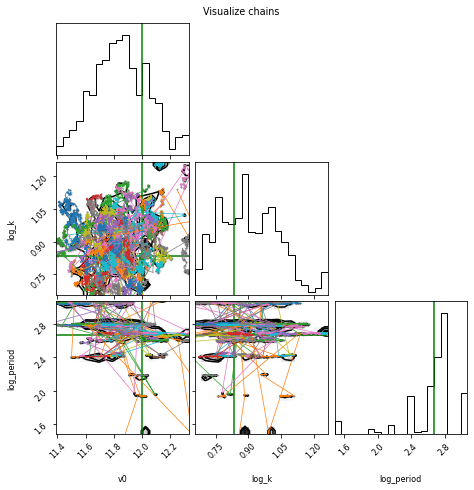

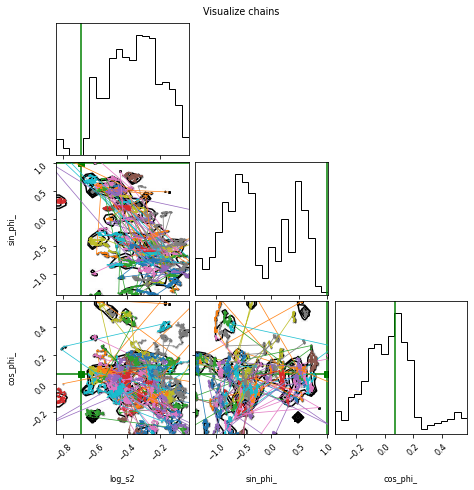

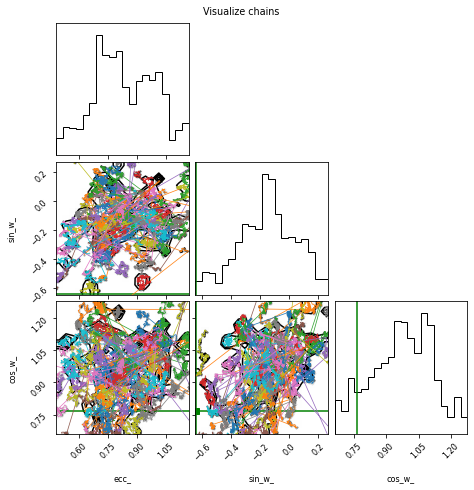

In [10]:
# fig_corner = draw_corner(chains, true_params, labels, labelpad=0.3)

for indices in [[0, 3, 2], [1, 4, 5], [6, 7, 8]]:

    fig_corner = draw_corner(chains[..., indices], true_params[indices], [labels[l] for l in indices], labelpad=0., n_plot_chains=50, n_last_spls=1000)
   

Superpose chains + samples from the Flow: Currently no overlap

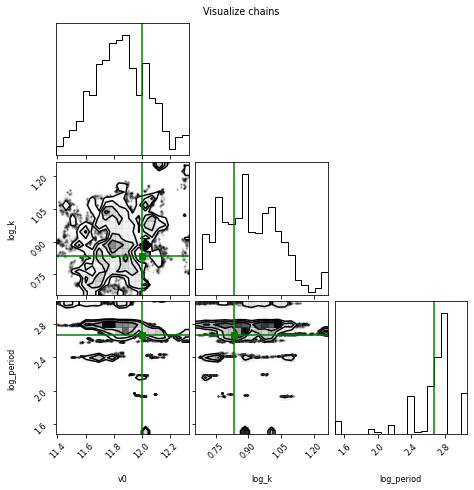

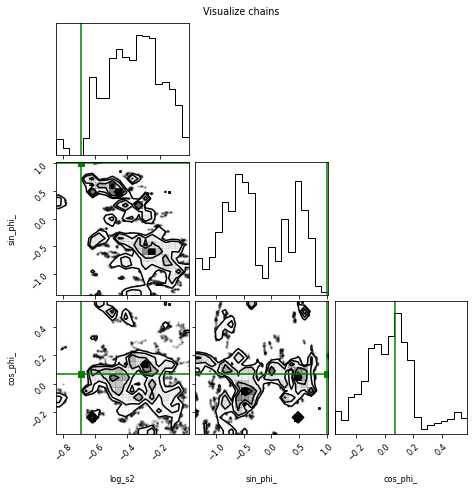

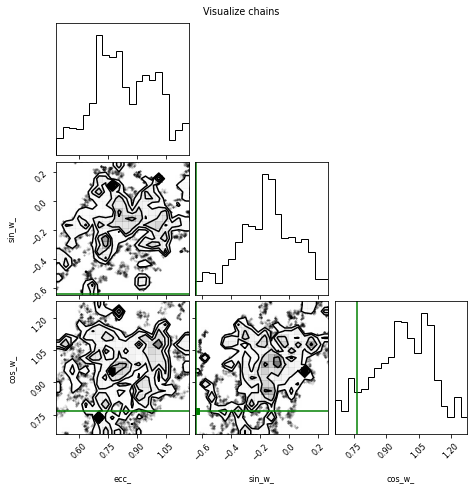

In [23]:
for indices in [[0, 3, 2], [1, 4, 5], [6, 7, 8]]:
    n_dim = chains.shape[-1]
    fig_corner = draw_corner(chains[..., indices], true_params[indices], [labels[l] for l in indices], labelpad=0., n_plot_chains=0, n_last_spls=1000)
    axes = np.array(fig_corner.axes).reshape((len(indices), len(indices)))
    for yy,yi in enumerate(indices):
        for xx,xi in enumerate(indices[:yy]):
            ax = axes[yy, xx]
            ax.plot(nf_samples[1][:, xi], nf_samples[1][:, yi], 'o', alpha=0.95)
    

Superpose chains + samples from the Flow

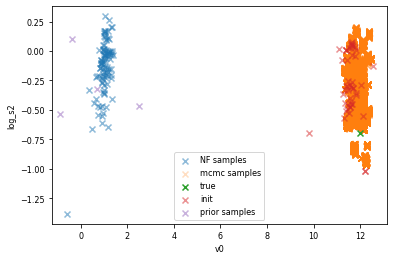

/Users/marylou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


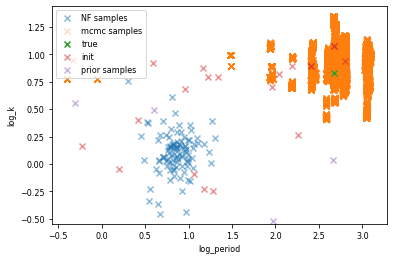

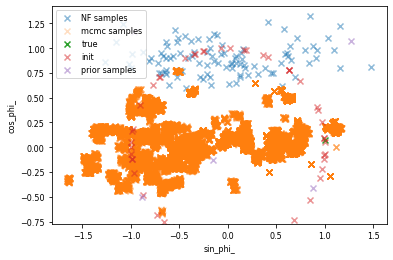

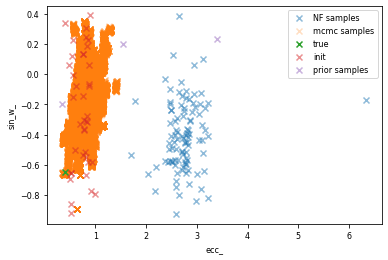

In [49]:

indices = [0, 1]
for indices in [[0,1], [2,3], [4,5], [6,7]]:

    plt.figure()
    ax = plt.subplot(111)
    plt.scatter(nf_samples[1][:, indices[0]], nf_samples[1][:, indices[1]], alpha=0.5, label='NF samples', marker='x')


    n_last_spls = 1000
    samples = chains[:, -n_last_spls:, :].reshape(-1, n_dim)
    plt.scatter(samples[:, indices[0]], samples[:, indices[1]], alpha=0.25, label='mcmc samples', marker='x')
    
    plt.scatter(true_params[indices[0]], true_params[indices[1]], label='true', marker='x')

    ax.autoscale(False)
    plt.scatter(optimized_init[:, indices[0]], optimized_init[:, indices[1]], alpha=0.5, label='init', marker='x')
    plt.scatter(prior_samples[:, indices[0]], prior_samples[:, indices[1]], alpha=0.5, label='prior samples', marker='x')
    plt.legend()
    plt.xlabel(labels[indices[0]])
    plt.ylabel(labels[indices[1]])



In [50]:
prior_samples

array([[ 1.60976283e+01,  5.31869989e+00,  1.01600428e+01,
         1.25543611e+01,  7.19188419e+00,  1.32273878e+01,
         9.65775141e+00,  1.31820280e+01,  8.54559299e+00,
         5.50828763e+00,  1.06984791e+01,  5.87374386e+00,
         1.43371853e+01,  1.16978556e+01,  5.28948740e+00,
         6.12466082e+00,  1.01195352e+01,  4.24786577e+00,
         4.08673287e+00,  5.14492780e+00,  1.38352000e+01,
         1.42729991e+01,  7.20503407e+00,  1.27141560e+01,
         5.65212909e+00,  1.16980183e+01,  8.41509951e+00,
         8.39955414e+00,  1.33132648e+01,  1.38616049e+01,
         9.56002969e+00,  9.83184087e+00,  1.10913788e+01,
         9.73547932e+00,  8.06997509e+00,  7.99854359e+00,
         1.72012689e+01,  5.85466595e+00,  7.11960467e+00,
         9.86906359e+00,  9.82126373e+00,  8.45922528e+00,
         9.26464872e+00,  9.31119015e+00,  1.01333059e+01,
         8.00624259e+00,  1.15967590e+01,  9.29611603e+00,
         5.05916708e+00,  7.79494777e+00],
       [-3.94

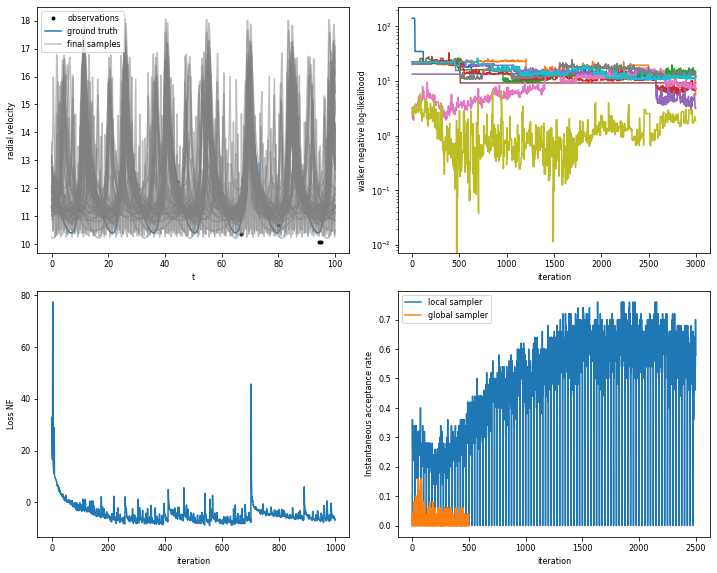

In [16]:

def log_posterior(x):
    return  log_likelihood(x.T, t, rv_err, rv_obs) + log_prior(x,**prior_kwargs)

fig_results = draw_kepler_results(chains, true_params, t, rv_obs, loss_vals,
                                  local_accs, global_accs, rv_model, log_posterior, get_kepler_params_and_log_jac)

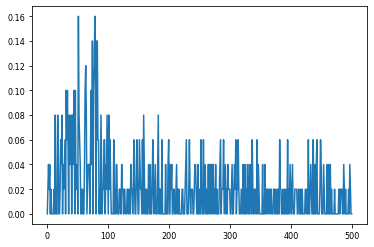

In [20]:
plt.plot(global_accs.mean(0))